In [1]:
import numpy as np
from functools import partial
import os

import llmize
from llmize import OPRO, HLMEA, HLMSA
import llmize.utils

def initialize_tsp(num_cities, seed=42):
    """
    Initializes the TSP with random city coordinates.
    :param num_cities: Number of cities
    :param seed: Random seed for reproducibility
    :return: Distance matrix
    """
    np.random.seed(seed)
    cities = (np.random.rand(num_cities, 2) * 100).astype(int)  # Random cities in 100x100 space with integer coordinates
    
    # Compute distance matrix
    dist_matrix = np.sqrt(((cities[:, np.newaxis] - cities[np.newaxis, :]) ** 2).sum(axis=2))
    return cities, dist_matrix

def objective_function(route, dist_matrix):
    """
    Computes the total travel distance for a given route.
    :param route: A permutation of city indices representing the tour
    :param dist_matrix: Precomputed distance matrix
    :return: Total distance of the route
    """

    # Check if route is valid
    if len(route) != dist_matrix.shape[0]:
        return 1000

    total_distance = sum(dist_matrix[route[i], route[i+1]] for i in range(len(route) - 1))
    total_distance += dist_matrix[route[-1], route[0]]  # Return to starting city
    return total_distance


/home/rizki/llmize/llmize/methods/hlmsa.py:103: SyntaxWarning: invalid escape sequence '\h'
  """
/home/rizki/llmize/llmize/methods/hlmsa.py:196: SyntaxWarning: invalid escape sequence '\h'
  hp_text = f"""The hyperparameter (cooling rate) used in previous step is: <hp> {hp} <\hp>"""


In [2]:
num_cities = 10
cities, dist_matrix = initialize_tsp(num_cities)
# generate 5 random routes and total distances
routes = [np.random.permutation(num_cities) for _ in range(16)]
total_distances = [objective_function(route, dist_matrix) for route in routes]

print(np.shape(dist_matrix))
print(routes)
print(total_distances)


(10, 10)
[array([1, 5, 4, 8, 0, 7, 6, 3, 2, 9]), array([8, 2, 5, 7, 3, 1, 9, 0, 4, 6]), array([0, 5, 2, 6, 3, 7, 4, 1, 8, 9]), array([4, 8, 1, 3, 0, 5, 2, 9, 7, 6]), array([2, 0, 4, 9, 8, 6, 7, 5, 1, 3]), array([4, 2, 7, 0, 6, 3, 5, 8, 9, 1]), array([5, 2, 7, 3, 0, 8, 9, 6, 1, 4]), array([1, 5, 2, 4, 3, 7, 9, 6, 8, 0]), array([3, 1, 4, 5, 8, 6, 9, 7, 0, 2]), array([2, 4, 5, 1, 7, 0, 9, 3, 8, 6]), array([7, 0, 1, 8, 3, 2, 4, 5, 9, 6]), array([6, 1, 3, 8, 7, 5, 4, 9, 0, 2]), array([4, 7, 8, 3, 5, 1, 0, 2, 9, 6]), array([1, 8, 5, 2, 9, 7, 4, 3, 0, 6]), array([8, 0, 4, 1, 9, 5, 7, 2, 6, 3]), array([0, 2, 1, 9, 7, 6, 3, 5, 4, 8])]
[np.float64(613.5193087234638), np.float64(602.1802669511267), np.float64(576.2101779671258), np.float64(479.824972974584), np.float64(618.7658994262118), np.float64(491.75025098532336), np.float64(419.41428755552556), np.float64(583.6571269951772), np.float64(569.3938426067974), np.float64(669.2406881556949), np.float64(606.7249570169968), np.float64(595.79139888

In [3]:
print(cities)

[[37 95]
 [73 59]
 [15 15]
 [ 5 86]
 [60 70]
 [ 2 96]
 [83 21]
 [18 18]
 [30 52]
 [43 29]]


In [4]:
with open("tsp_problem.txt", "r") as f:
    problem_text = f.read()

# Initialize the OPRO optimizer
opro = OPRO(problem_text=problem_text, obj_func=partial(objective_function, dist_matrix=dist_matrix),
            llm_model="gemini-2.0-flash", api_key=os.getenv("GEMINI_API_KEY"))

prompt = opro.get_sample_prompt(init_samples=routes, init_scores=total_distances, optimization_type="minimize")
response = opro.get_sample_response(prompt)

llmize.utils.pretty_print(prompt=prompt, response=response)



Prompt: I want you to help me solve the Traveling Salesman Problem (TSP) for 10 randomly placed cities within a 
100x100 coordinate space. The objective is to find the shortest possible route that visits each city exactly once 
and returns to the starting point. Your task is to find a trace,
with the shortest possible length, that traverses each point exactly once.

In the TSP, the goal is to minimize the total distance traveled by visiting each city only once and returning to 
the starting city, creating a closed loop. The cities are represented as points on a 2D grid, where each city has 
an x and y coordinate within the 100x100 space.

Below are each city coordinate  from 0 to 9:
 [37, 95]
 [73, 59]
 [15, 15]
 [ 5, 86]
 [60, 70]
 [ 2, 96]
 [83, 21]
 [18, 18]
 [30, 52]
 [43, 29]

For each pair of cities, the distance between them is calculated using the Euclidean distance formula. The distance
between two cities is the square root of the sum of the squared differences between their x and y coordinates.
Below are some examples of solutions and their scores:

<sol> 1,5,4,8,0,7,6,3,2,9 <\sol>
score: 613.52

<sol> 8,2,5,7,3,1,9,0,4,6 <\sol>
score: 602.18

<sol> 0,5,2,6,3,7,4,1,8,9 <\sol>
score: 576.21

<sol> 4,8,1,3,0,5,2,9,7,6 <\sol>
score: 479.82

<sol> 2,0,4,9,8,6,7,5,1,3 <\sol>
score: 618.77

<sol> 4,2,7,0,6,3,5,8,9,1 <\sol>
score: 491.75

<sol> 5,2,7,3,0,8,9,6,1,4 <\sol>
score: 419.41

<sol> 1,5,2,4,3,7,9,6,8,0 <\sol>
score: 583.66

<sol> 3,1,4,5,8,6,9,7,0,2 <\sol>
score: 569.39

<sol> 2,4,5,1,7,0,9,3,8,6 <\sol>
score: 669.24

<sol> 7,0,1,8,3,2,4,5,9,6 <\sol>
score: 606.72

<sol> 6,1,3,8,7,5,4,9,0,2 <\sol>
score: 595.79

<sol> 4,7,8,3,5,1,0,2,9,6 <\sol>
score: 495.71

<sol> 1,8,5,2,9,7,4,3,0,6 <\sol>
score: 520.16

<sol> 8,0,4,1,9,5,7,2,6,3 <\sol>
score: 511.41

<sol> 0,2,1,9,7,6,3,5,4,8 <\sol>
score: 544.67


Generate exactly 5 new solutions that:
- Are distinct from all previous solutions.
- Have lower scores than the lowest provided.
- Respect the relationships based on logical reasoning.

Each solution should start with <sol> and end with <\sol> with a comma between parameters. 
Make sure the length of solutions match examples given. Don't guess for the scores as they will be calculated by an
objective function.

Response: Here are 5 new solutions that aim to improve upon the best score (419.41) from the provided examples. 
These solutions are generated using a combination of heuristics, including nearest neighbor and small, random 
perturbations to existing good solutions. The goal is to find potentially better routes by exploring variations 
around promising paths.

<sol> 7,2,8,9,1,4,5,0,3,6 <\sol>
<sol> 9,8,7,1,4,5,0,3,6,2 <\sol>
<sol> 7,9,8,1,4,5,0,3,6,2 <\sol>
<sol> 9,7,8,1,4,5,0,3,6,2 <\sol>
<sol> 6,3,0,5,4,1,9,8,7,2 <\sol>

In [5]:
# Initialize the HLMEA optimizer
hlmea = HLMEA(problem_text=problem_text, obj_func=partial(objective_function, dist_matrix=dist_matrix),
            llm_model="gemini-2.0-flash", api_key=os.getenv("GEMINI_API_KEY"))

prompt = hlmea.get_sample_prompt(init_samples=routes, init_scores=total_distances, batch_size=16, optimization_type="minimize")
response = hlmea.get_sample_response(prompt)

llmize.utils.pretty_print(prompt=prompt, response=response)


Prompt: 
You are a hyper-heuristic LLM-driven evolutionary algorithm that generates diverse and optimized solutions for a 
given problem.  
You can adaptively set hyperparameters to enhance solution quality and exploration.  

## Problem Description  
You need to optimize a given problem by evolving a set of candidate solutions. The objective is to iteratively 
improve solutions using evolutionary strategies, ensuring diversity and avoiding premature convergence.  

I want you to help me solve the Traveling Salesman Problem (TSP) for 10 randomly placed cities within a 100x100 
coordinate space. The objective is to find the shortest possible route that visits each city exactly once and 
returns to the starting point. Your task is to find a trace,
with the shortest possible length, that traverses each point exactly once.

In the TSP, the goal is to minimize the total distance traveled by visiting each city only once and returning to 
the starting city, creating a closed loop. The cities are represented as points on a 2D grid, where each city has 
an x and y coordinate within the 100x100 space.

Below are each city coordinate  from 0 to 9:
 [37, 95]
 [73, 59]
 [15, 15]
 [ 5, 86]
 [60, 70]
 [ 2, 96]
 [83, 21]
 [18, 18]
 [30, 52]
 [43, 29]

For each pair of cities, the distance between them is calculated using the Euclidean distance formula. The distance
between two cities is the square root of the sum of the squared differences between their x and y coordinates.
Below are some examples of solutions and their scores from the previous population:
The solutions below are generated randomly.

<sol> 1,5,4,8,0,7,6,3,2,9 <\sol>
score: 613.52

<sol> 8,2,5,7,3,1,9,0,4,6 <\sol>
score: 602.18

<sol> 0,5,2,6,3,7,4,1,8,9 <\sol>
score: 576.21

<sol> 4,8,1,3,0,5,2,9,7,6 <\sol>
score: 479.82

<sol> 2,0,4,9,8,6,7,5,1,3 <\sol>
score: 618.77

<sol> 4,2,7,0,6,3,5,8,9,1 <\sol>
score: 491.75

<sol> 5,2,7,3,0,8,9,6,1,4 <\sol>
score: 419.41

<sol> 1,5,2,4,3,7,9,6,8,0 <\sol>
score: 583.66

<sol> 3,1,4,5,8,6,9,7,0,2 <\sol>
score: 569.39

<sol> 2,4,5,1,7,0,9,3,8,6 <\sol>
score: 669.24

<sol> 7,0,1,8,3,2,4,5,9,6 <\sol>
score: 606.72

<sol> 6,1,3,8,7,5,4,9,0,2 <\sol>
score: 595.79

<sol> 4,7,8,3,5,1,0,2,9,6 <\sol>
score: 495.71

<sol> 1,8,5,2,9,7,4,3,0,6 <\sol>
score: 520.16

<sol> 8,0,4,1,9,5,7,2,6,3 <\sol>
score: 511.41

<sol> 0,2,1,9,7,6,3,5,4,8 <\sol>
score: 544.67


The best solution has the lowest score from the provided population.

## Your Task  

Generate **exactly 16 diverse solutions** for the next generation using an evolutionary algorithm.  

### **Step 1: Adaptive Hyperparameter Selection**  
- Determine the **elitism rate, mutation rate, and crossover rate**.  
- Prioritize **high mutation rate and high crossover rate** to enhance diversity and avoid premature convergence.  

### **Step 2: Selection (Parent Selection)**  
- Select the best solutions from the previous population using **Roulette Wheel Selection, Tournament Selection, or
Rank-Based Selection**.  
- Ensure that diverse parents are chosen to prevent premature convergence.  

### **Step 3: Crossover (Recombination of Parents)**  
- Generate new solutions using appropriate crossover techniques such as **Ordered Crossover (OX), Partially Mapped 
Crossover (PMX), or problem-specific recombination operators**.  
- Apply crossover **only if it introduces diversity**.  

### **Step 4: Mutation (Introducing Variations)**  
- Apply mutation based on the mutation rate. Mutation operators may include:  
  - **Swap Mutation**: Swap two random elements.  
  - **Insert Mutation**: Insert an element at a different position.  
  - **Inversion Mutation**: Reverse a segment of the solution.  
  - **Problem-Specific Mutations**: Apply domain-relevant perturbations.  
- Ensure each generated solution is **unique** compared to existing ones.  

### **Step 5: Uniqueness Enforcement**  
- **Check if a newly generated solution is identical to any previous or current solutions**.  
- If duplication occurs,

Response: <hp> 0.1, 0.8, 0.9 <\hp>
<sol> 4,2,7,3,0,8,9,6,1,5 <\sol>
<sol> 7,0,1,8,3,2,4,5,9,6 <\sol>
<sol> 1,8,5,2,9,7,4,3,0,6 <\sol>
<sol> 8,0,4,1,9,5,7,2,6,3 <\sol>
<sol> 5,2,7,3,0,8,9,6,4,1 <\sol>
<sol> 4,8,1,3,0,5,2,9,7,6 <\sol>
<sol> 2,0,4,9,8,6,7,5,1,3 <\sol>
<sol> 4,2,7,0,6,3,5,8,9,1 <\sol>
<sol> 5,2,7,3,0,8,9,1,6,4 <\sol>
<sol> 1,5,2,4,3,7,9,6,8,0 <\sol>
<sol> 3,1,4,5,8,6,9,7,0,2 <\sol>
<sol> 2,4,5,1,7,0,9,3,8,6 <\sol>
<sol> 6,1,3,8,7,5,4,9,0,2 <\sol>
<sol> 4,7,8,3,5,1,0,2,9,6 <\sol>
<sol> 0,2,1,9,7,6,3,5,4,8 <\sol>
<sol> 4,1,5,2,7,0,9,3,8,6 <\sol>

In [6]:
# Initialize the HLMSA optimizer
hlmsa = HLMSA(problem_text=problem_text, obj_func=partial(objective_function, dist_matrix=dist_matrix),
            llm_model="gemini-2.0-flash", api_key=os.getenv("GEMINI_API_KEY"))

prompt = hlmsa.get_sample_prompt(init_samples=routes, init_scores=total_distances, batch_size=16, optimization_type="minimize")
response = hlmsa.get_sample_response(prompt)

llmize.utils.pretty_print(prompt=prompt, response=response)


Prompt: 
You are a hyper-heuristic LLM-driven optimization algorithm using Simulated Annealing to explore and refine 
solutions.  
You dynamically adapt the cooling rate and perturbation strategies to balance exploration and exploitation.  

## Problem Description  
You need to optimize a given problem by evolving a set of candidate solutions. The objective is to iteratively 
improve solutions while maintaining diversity and avoiding local optima.  

I want you to help me solve the Traveling Salesman Problem (TSP) for 10 randomly placed cities within a 100x100 
coordinate space. The objective is to find the shortest possible route that visits each city exactly once and 
returns to the starting point. Your task is to find a trace,
with the shortest possible length, that traverses each point exactly once.

In the TSP, the goal is to minimize the total distance traveled by visiting each city only once and returning to 
the starting city, creating a closed loop. The cities are represented as points on a 2D grid, where each city has 
an x and y coordinate within the 100x100 space.

Below are each city coordinate  from 0 to 9:
 [37, 95]
 [73, 59]
 [15, 15]
 [ 5, 86]
 [60, 70]
 [ 2, 96]
 [83, 21]
 [18, 18]
 [30, 52]
 [43, 29]

For each pair of cities, the distance between them is calculated using the Euclidean distance formula. The distance
between two cities is the square root of the sum of the squared differences between their x and y coordinates.
Below are some examples of solutions and their scores from the previous population:
The solutions below are generated randomly.

<sol> 1,5,4,8,0,7,6,3,2,9 <\sol>
score: 613.52

<sol> 8,2,5,7,3,1,9,0,4,6 <\sol>
score: 602.18

<sol> 0,5,2,6,3,7,4,1,8,9 <\sol>
score: 576.21

<sol> 4,8,1,3,0,5,2,9,7,6 <\sol>
score: 479.82

<sol> 2,0,4,9,8,6,7,5,1,3 <\sol>
score: 618.77

<sol> 4,2,7,0,6,3,5,8,9,1 <\sol>
score: 491.75

<sol> 5,2,7,3,0,8,9,6,1,4 <\sol>
score: 419.41

<sol> 1,5,2,4,3,7,9,6,8,0 <\sol>
score: 583.66

<sol> 3,1,4,5,8,6,9,7,0,2 <\sol>
score: 569.39

<sol> 2,4,5,1,7,0,9,3,8,6 <\sol>
score: 669.24

<sol> 7,0,1,8,3,2,4,5,9,6 <\sol>
score: 606.72

<sol> 6,1,3,8,7,5,4,9,0,2 <\sol>
score: 595.79

<sol> 4,7,8,3,5,1,0,2,9,6 <\sol>
score: 495.71

<sol> 1,8,5,2,9,7,4,3,0,6 <\sol>
score: 520.16

<sol> 8,0,4,1,9,5,7,2,6,3 <\sol>
score: 511.41

<sol> 0,2,1,9,7,6,3,5,4,8 <\sol>
score: 544.67


The best solution has the lowest score from the provided population.

## Your Task  

Generate **exactly 16 diverse solutions** for the next iteration using Simulated Annealing.  

### **Step 1: Adaptive Cooling Rate Selection**  
- Choose an appropriate **cooling rate (α)** to control the acceptance probability of worse solutions.  
- A **higher cooling rate (e.g., α → 1)** maintains exploration, while a **lower cooling rate (e.g., α → 0.8)** 
increases exploitation.  
- Balance between exploration and exploitation dynamically based on the quality and diversity of previous 
solutions.  

### **Step 2: Solution Perturbation (Neighborhood Search)**  
- Generate new candidate solutions by applying one or more perturbation strategies:  
  - **Small Perturbation** (e.g., minor tweaks for fine-tuning).  
  - **Large Perturbation** (e.g., drastic changes to escape local optima).  
  - **Problem-Specific Perturbations**.
- Choose perturbation strength based on the cooling rate and current solution landscape.  

### **Step 3: Uniqueness Enforcement**  
- Ensure that each generated solution is **unique** compared to previous and current ones.  
- If a duplicate is found, **apply additional perturbations** until uniqueness is achieved.  

## **Output Format**  

Return exactly **16 unique solutions** and the chosen hyperparameters in the following format:  

### **Hyperparameters Output**  

<hp> cooling_rate <\hp>

### **Solutions Output**  

<sol> param1, param2, ..., paramn <\sol>

**Only provide the solutions and hyperparameters—do not include any extra text. Do not include any code.**  

Response: <hp> cooling_rate 0.92 <\hp>
<sol> 5,2,7,3,0,8,9,6,1,4 </sol>[ /bold cyan]
<sol> 4,7,8,3,5,1,0,2,9,6 </sol>[ /bold cyan]
<sol> 4,2,7,0,6,3,5,8,9,1 </sol>[ /bold cyan]
<sol> 2,4,5,1,7,0,9,3,8,6 </sol>[ /bold cyan]
<sol> 5, 2, 7, 3, 0, 8, 9, 6, 4, 1 </sol>[ /bold cyan]
<sol> 5, 2, 7, 3, 0, 8, 9, 1, 6, 4 </sol>[ /bold cyan]
<sol> 5, 2, 7, 3, 0, 8, 9, 1, 4, 6 </sol>[ /bold cyan]
<sol> 5, 2, 7, 3, 0, 8, 6, 9, 4, 1 </sol>[ /bold cyan]
<sol> 5, 2, 7, 3, 0, 6, 8, 9, 4, 1 </sol>[ /bold cyan]
<sol> 5, 2, 7, 3, 6, 0, 8, 9, 4, 1 </sol>[ /bold cyan]
<sol> 5, 2, 7, 6, 3, 0, 8, 9, 4, 1 </sol>[ /bold cyan]
<sol> 5, 2, 6, 7, 3, 0, 8, 9, 4, 1 </sol>[ /bold cyan]
<sol> 5, 6, 2, 7, 3, 0, 8, 9, 4, 1 </sol>[ /bold cyan]
<sol> 5, 6, 2, 7, 3, 0, 8, 9, 1, 4 </sol>[ /bold cyan]
<sol> 5, 6, 2, 7, 3, 0, 9, 8, 1, 4 </sol>[ /bold cyan]
<sol> 5, 6, 2, 7, 3, 9, 0, 8, 1, 4 </sol>[ /bold cyan]

In [7]:
from llmize.utils.parsing import parse_pairs, parse_response

pairs, hp = parse_response(response, hp_parse=True)
print(len(pairs))
print(pairs)
print(hp)


16
[[5, 2, 7, 3, 0, 8, 9, 6, 1, 4], [4, 7, 8, 3, 5, 1, 0, 2, 9, 6], [4, 2, 7, 0, 6, 3, 5, 8, 9, 1], [2, 4, 5, 1, 7, 0, 9, 3, 8, 6], [5, 2, 7, 3, 0, 8, 9, 6, 4, 1], [5, 2, 7, 3, 0, 8, 9, 1, 6, 4], [5, 2, 7, 3, 0, 8, 9, 1, 4, 6], [5, 2, 7, 3, 0, 8, 6, 9, 4, 1], [5, 2, 7, 3, 0, 6, 8, 9, 4, 1], [5, 2, 7, 3, 6, 0, 8, 9, 4, 1], [5, 2, 7, 6, 3, 0, 8, 9, 4, 1], [5, 2, 6, 7, 3, 0, 8, 9, 4, 1], [5, 6, 2, 7, 3, 0, 8, 9, 4, 1], [5, 6, 2, 7, 3, 0, 8, 9, 1, 4], [5, 6, 2, 7, 3, 0, 9, 8, 1, 4], [5, 6, 2, 7, 3, 9, 0, 8, 1, 4]]
[0.92]


In [8]:
from llmize.callbacks import EarlyStopping, AdaptTempOnPlateau, OptimalScoreStopping

# Define the early stopping callback
earlystop_callback = EarlyStopping(monitor='best_score', min_delta=1.0, patience=50, verbose=1)

# Define the optimal score stopping callback
optimal_score_callback = OptimalScoreStopping(optimal_score=290.22, tolerance=0.01)

# Define the temperature adaptation callback
adapt_temp_callback = AdaptTempOnPlateau(monitor='best_score', init_temperature=1.0, min_delta=1.0, patience=20, factor=1.1, max_temperature=1.9, verbose=1)

In [9]:
callbacks=[earlystop_callback, adapt_temp_callback, optimal_score_callback]
print(callbacks)

[<llmize.callbacks.early_stopping.EarlyStopping object at 0x7faedb0f12b0>, <llmize.callbacks.adapt_temp_on_plateau.AdaptTempOnPlateau object at 0x7faedb0f1a90>, <llmize.callbacks.optimal_score_stopping.OptimalScoreStopping object at 0x7faedb0f1550>]


In [10]:
results = opro.minimize(init_samples=routes, init_scores=total_distances, num_steps=250, batch_size=16, callbacks=callbacks)
#results = hlmea.minimize(init_samples=routes, init_scores=total_distances, num_steps=250, batch_size=16, callbacks=callbacks, verbose=1)

#results = hlmsa.minimize(init_samples=routes, init_scores=total_distances, num_steps=250, batch_size=16, callbacks=callbacks, verbose=1)

Running HLMSA optimization with 250 steps and batch size 16...
Step 0 - SA Temperature: 1000.00 - Best Initial Score: 419.41, Average Initial Score: 556.15
Step 1 - SA Temperature: 920.00 - Current Best Score: 419.41, Average Batch Score: 528.14 - Best Batch Score: 419.41
No improvement in best_score. Patience count: 1/50
Step 2 - SA Temperature: 874.00 - Current Best Score: 419.41, Average Batch Score: 522.97 - Best Batch Score: 419.41
No improvement in best_score. Patience count: 2/50
Step 3 - SA Temperature: 847.78 - Current Best Score: 419.41, Average Batch Score: 524.27 - Best Batch Score: 419.41
No improvement in best_score. Patience count: 3/50
Step 4 - SA Temperature: 830.82 - Current Best Score: 419.41, Average Batch Score: 523.68 - Best Batch Score: 456.50
No improvement in best_score. Patience count: 4/50
Step 5 - SA Temperature: 805.90 - Current Best Score: 419.41, Average Batch Score: 525.08 - Best Batch Score: 456.50
No improvement in best_score. Patience count: 5/50
Step

In [11]:
print(results)

{'best_solution': [0, 5, 3, 7, 2, 9, 6, 1, 4, 8], 'best_score': np.float64(325.90073847783543), 'best_score_history': [np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41

In [12]:
print(results['best_solution'])
print(results['best_score'])

[0, 5, 3, 7, 2, 9, 6, 1, 4, 8]
325.90073847783543


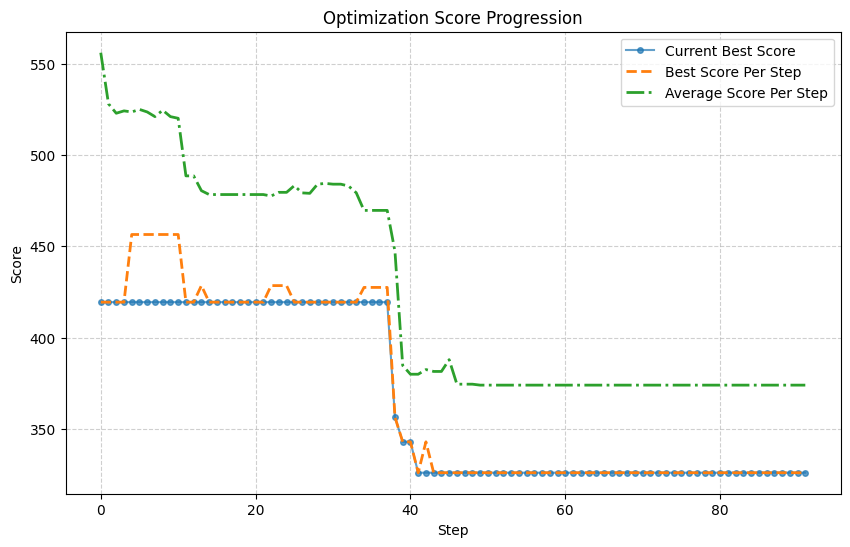

In [13]:
from llmize.utils.plotting import plot_scores

plot_scores(results)

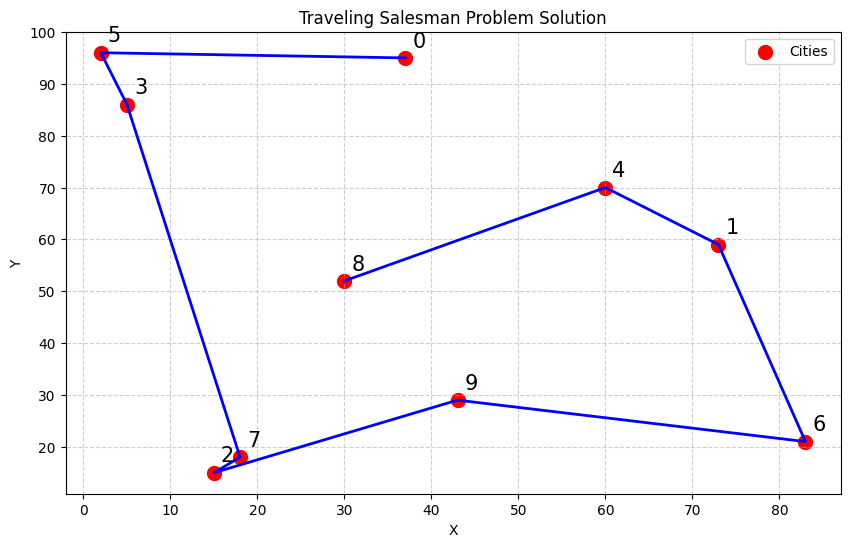

In [14]:
# Plot city coordinates along with traces from best solution
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.scatter(cities[:, 0], cities[:, 1], c='r', s=100, label='Cities')

solution = results['best_solution']
plt.plot(cities[solution, 0], cities[solution, 1], color='b', linewidth=2)

# Annotate city number a distance to the dots
for i, city in enumerate(cities):
    plt.annotate(str(i), xy=(city[0], city[1]), xytext=(5, 5),fontsize=15, textcoords='offset points', ha='left', va='bottom')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Traveling Salesman Problem Solution')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [15]:
print(solution)

[0, 5, 3, 7, 2, 9, 6, 1, 4, 8]
